In [1]:
!pip install keras

In [2]:
import numpy as np
import keras
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm as tqdm

/root/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


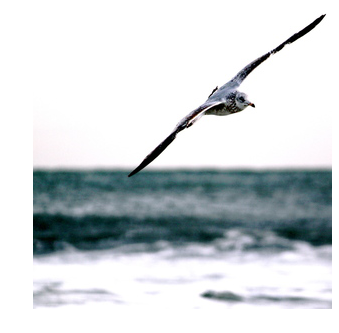

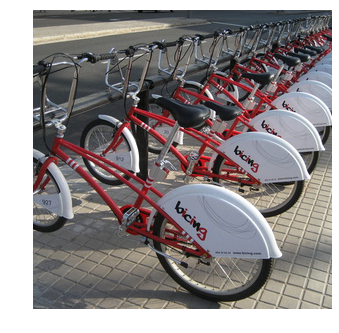

In [3]:
from keras.preprocessing import image
import os.path as osp
import os
import seaborn as sns

batch_size = 32
DATASET_ROOT = '/root/datasets/tcu-imagenet/v0.0.2'

image_paths_bicycle = os.listdir(osp.join(DATASET_ROOT, 'bicycle'))
image_paths_bicycle = [os.path.join(DATASET_ROOT,'bicycle', path) for path in image_paths_bicycle]

image_paths_bird = os.listdir(osp.join(DATASET_ROOT, 'bird'))
image_paths_bird = [os.path.join(DATASET_ROOT,'bird', path) for path in image_paths_bird]

# Truncate eval dataset
image_paths_bird = image_paths_bird[:500]
image_paths_bicycle = image_paths_bicycle[:500]

def show_image(im):
    plt.axis('off')
    im = image.load_img(im, target_size=(299, 299))
    plt.imshow(im)
    plt.show()
    
show_image(image_paths_bird[0])
show_image(image_paths_bicycle[0])

In [4]:
from keras.preprocessing import image
import numpy as np


In [5]:
if True:
    from keras.applications.resnet50 import ResNet50
    from keras.applications.resnet50 import preprocess_input, decode_predictions
    model = ResNet50(weights='imagenet')
    SIZE = (224,224)
    
else: 
    from keras.applications.inception_resnet_v2 import preprocess_input, decode_predictions
    from keras.applications.inception_resnet_v2 import InceptionResNetV2
    model = InceptionResNetV2(weights='imagenet')
    SIZE = (299,299)



Predicted: [('n01608432', 'kite', 0.27146953), ('n02051845', 'pelican', 0.26207525), ('n02058221', 'albatross', 0.20641266)]


/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


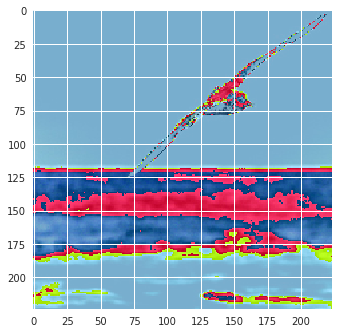

In [6]:
img = image.load_img(image_paths_bird[0], target_size=SIZE)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])

plt.imshow(x[0])
plt.show()

In [7]:
print(np.max(x), np.min(x), np.mean(x))

151.061 -123.68 86.66834


In [8]:
# Collect all the logits and images in arrays
import os
image_paths = image_paths_bicycle + image_paths_bird

# bird is one
y_true = np.concatenate([np.zeros((len(image_paths_bicycle),)), np.ones((len(image_paths_bird),))])

In [9]:

def to_batches(iterable, batch_size):
    return [iterable[i * batch_size:(i + 1) * batch_size]
          for i in range((len(iterable) + batch_size - 1) // batch_size)]

image_patch_batches = to_batches(image_paths, batch_size)


## Run keras model

In [10]:
preds = []
for batch in tqdm(image_patch_batches):
    x_batch = []
    for img_path in batch:
        img = image.load_img(img_path, target_size=SIZE)
        x_batch.append(image.img_to_array(img))

    x_batch = np.stack(x_batch)
    x_batch = preprocess_input(x_batch)
    preds.append(model.predict(x_batch))
    
preds = np.concatenate(preds)

100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


In [11]:
preds.shape

(1000, 1000)

## Run our model

In [12]:
from absl import app as absl_app
from absl import flags
absl_app.run(lambda x: 0, argv=["o"])

SystemExit: 0

/root/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2889: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [17]:

from unrestricted_advex.resnet.eval_attacks import sess_with_loaded_model
import tensorflow as tf

from unrestricted_advex.resnet.spatial_attack import EvalModeAttackableModel

with tf.Graph().as_default():
  eval_model = EvalModeAttackableModel()
  with sess_with_loaded_model() as sess:
    logits = []
    for batch in tqdm(image_patch_batches):
      x_batch = []
      for img_path in batch:
          img = image.load_img(img_path, target_size=SIZE)
          x_batch.append(image.img_to_array(img))

      x_batch = np.stack(x_batch)
      x_batch = preprocess_input(x_batch)
      logits_batch = sess.run(eval_model.logits,
                     feed_dict={
                       eval_model.x_input: x_batch,
                     })
      logits.append(logits_batch)

    logits = np.concatenate(logits)

INFO:tensorflow:Graph was finalized.


I0808 01:40:17.805608 140326982600448 tf_logging.py:115] Graph was finalized.


INFO:tensorflow:Restoring parameters from /root/tb/tcu-imagenet/full-imagenet-72b3e7c/model.ckpt-61250


I0808 01:40:17.809431 140326982600448 tf_logging.py:115] Restoring parameters from /root/tb/tcu-imagenet/full-imagenet-72b3e7c/model.ckpt-61250


INFO:tensorflow:Running local_init_op.


I0808 01:40:18.160835 140326982600448 tf_logging.py:115] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0808 01:40:18.186895 140326982600448 tf_logging.py:115] Done running local_init_op.
100%|██████████| 32/32 [00:05<00:00,  6.32it/s]


In [18]:
print(logits.shape)

logits_orig = logits

logits = logits_orig[:, 1:]

print(logits.shape)

(1000, 1001)
(1000, 1000)


In [19]:
# TODO: See if more classes helps here
BIRD_CLASSES = list(range(80,100+1))
BICYCLE_CLASSES = [671, 444]

print(BIRD_CLASSES)

bird_logits = np.max(logits[:, BIRD_CLASSES], axis=1)
bicycle_logits = np.max(logits[:, BICYCLE_CLASSES], axis=1)


[80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]


In [20]:
is_correct = (bird_logits > bicycle_logits) == y_true.astype(np.bool)
print("accuracy: ")
np.mean(is_correct)

# Previous: 0.964517625231911
# use my graphing code

accuracy: 


0.992

(1000, 2)


/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


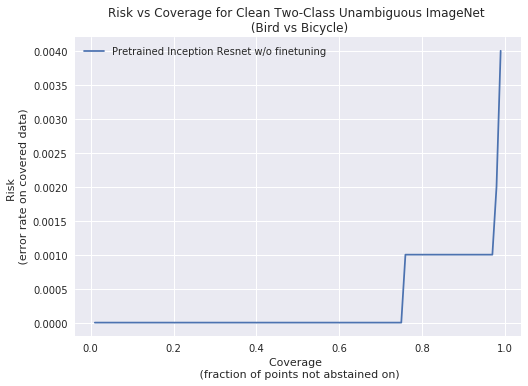

In [35]:
labels = bird_logits > bicycle_logits


def softmax(x, temperature=1.0):
    """Compute softmax values for each sets of scores in x."""
    x = x / temperature
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / np.sum(e_x, axis=1, keepdims=True)

logits = np.vstack([bird_logits, bicycle_logits]).T


print(logits.shape)
softmaxed_logits = softmax(logits)
confidences = np.max(softmaxed_logits, axis=1)

# confidences = np.max(logits, axis=1)


def plot_confident_error_rate(labels, confidences, y_true, title="Risk vs Coverage"):
    sorted_confidences = list(sorted(confidences, reverse=True))

    coverages = np.linspace(0.01, .99, 99)
    cov_to_confident_error_idxs = []

    for coverage in coverages:    
        threshold = sorted_confidences[int(coverage * len(labels))]
        confident_mask = confidences >= threshold
        confident_error_mask = (y_true != labels) * confident_mask
        confident_error_idx = confident_error_mask.nonzero()[0]
        
        cov_to_confident_error_idxs.append(confident_error_idx)
        
    plt.plot(coverages, [float(len(idxs)) / len(labels) for idxs in cov_to_confident_error_idxs])
    plt.title(title)
    plt.ylabel("Risk \n (error rate on covered data)")
    plt.xlabel("Coverage \n (fraction of points not abstained on)")
    
    plt.legend(["Pretrained Inception Resnet w/o finetuning"])
    plt.show()
    return cov_to_confident_error_idxs
    
cov_to_confident_error_idxs = plot_confident_error_rate(
    labels, confidences, y_true, title="Risk vs Coverage for Clean Two-Class Unambiguous ImageNet \n (Bird vs Bicycle)")

In [33]:
print(len(cov_to_confident_error_idxs))

99


True: bicycle
Pred: bird


/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


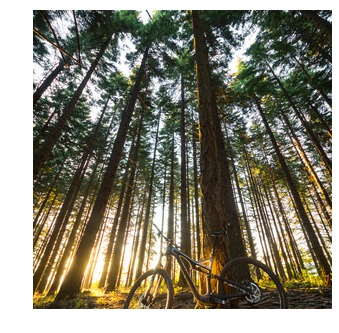

In [34]:
incorrect_idxs = cov_to_confident_error_idxs[90]

for idx in incorrect_idxs:
    print("True: %s" %('bird' if y_true[idx] else 'bicycle'))
    print("Pred: %s" %('bird' if labels[idx] else 'bicycle'))
#     print(np.argmax(preds[idx, BOAT_CLASSES]))
    show_image(image_paths[idx])

In [31]:
4

4